<a href="https://colab.research.google.com/github/dalatorrem/Diplomado_Metodos_UCentral_2023/blob/main/Lectura_25_Linear_Regression_Part_III_stud_mod_class_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

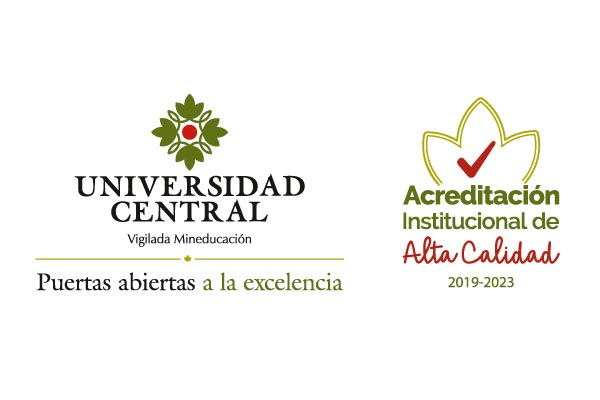

In [2]:
import numpy as np
import pandas as pd
import plotly.express as px


df = pd.DataFrame()
df['x'] = np.arange(1000)
df['y'] = 150 + 1*df['x'] + np.random.normal(loc=0, scale=50,size=1000)
px.scatter(df, x='x', y='y', trendline='ols')

In [3]:
x_atipico = 1500
y_atipico = -50_000
df = pd.DataFrame()
df['x'] = np.arange(1000)
df['y'] = 150 + 1*df['x'] + np.random.normal(loc=0, scale=50,size=1000)

df = pd.concat([df, pd.DataFrame([[x_atipico, y_atipico]], columns=['x','y'])], axis=0)
px.scatter(df, x='x', y='y', trendline='ols')

## ***¿Cuánto deberían costar las propiedades en Milwaukee, Wisconsin? (Parte I)***



### ***Objetivos.***

Nuestro mundo se comporta de acuerdo a tantas variables que están fuera de nuestro control, que esperar que un modelo simple explique *perfectamente* esto es imposible. Sin embargo, podemos intentar mitigar este problema mejorando nuestra comprensión de los errores que producen los modelos. Esto nos permitirá actualizar el modelo y así buscar mejorar su utilidad.

El objetivo principal de esta lectura es aprender cómo realizar un análisis adecuado de los errores (residuales) de los modelos de regresión lineal y cómo utilizar este análisis para realizar mejoras en el modelo. Nuevamente las transformaciones de variables y un estudio de valores atípicos (outliyers) en los residuos pueden ayudar con esta tarea.



In [4]:
import pandas                   as pd
import numpy                    as np
import matplotlib.pyplot        as plt
import seaborn                  as sns
from   scipy                    import stats
import statsmodels.formula.api  as smf
import scipy
import warnings
##
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (15,6)
warnings.filterwarnings("ignore")
url_base = "https://raw.githubusercontent.com/lacamposm/Fundamentos_Analitica/main/data/"

### ***Introducción***

***Contexto empresarial.*** Los mercados inmobiliarios a veces pueden ser irracionales, y comprar una casa ciertamente puede ser un proceso emocional y altamente psicológico. Por ejemplo, el precio de venta puede anclar las negociaciones, y puede ser muy difícil como comprador “olvidar” ese número inicial.

Es usted un promotor inmobiliario que compra propiedades con frecuencia. Sería muy útil obtener una estimación justa del precio de una propiedad antes de ver el precio de venta, en función de características como su tamaño y ubicación. Además de convertirlo en un comprador más informado, tener un modelo de fijación de precios podría tener múltiples usos, como detectar automáticamente propiedades con precios bajos que salen al mercado, o estimar el valor agregado a una propiedad si se amplía, se divide en apartamentos o se convierte en oficinas.

***Problema comercial.*** Su tarea es ***construir un modelo para predecir los precios de las propiedades en la ciudad de Milwaukee, Wisconsin***.

***Contexto analítico.*** La data consta de ventas de propiedades residenciales en Milwaukee, Wisconsin, de 2002 a 2018. La regresión lineal es una idea simple: al final del día, solo estamos ajustando una superficie a través de los datos. Pero su simplicidad también es su fuerza: los coeficientes son fácilmente interpretables y es fácil de entender el modelo subyacente. Sin embargo, muchas cosas pueden salir mal durante el proceso de ajuste de un modelo lineal.

La lectura busca seguir la ruta:

1. Se explorarán los datos para detectar algunos patrones iniciales.

2. Analizar los ***residuales***, la diferencia entre los valores reales y sus estimaciones, para diagnosticar un modelo inicial.

3. Relizar transformaciones de variables para buscar solucionar parcialmente los problemas.

4. Ver cómo lidiar con los valores atípicos para mejorar aún más el modelo.

---


In [5]:
data_clean = pd.read_csv(url_base +"prueba_MLR.csv")
data_clean.head()

,PropType,Taxkey,Address,CondoProject,District,Nbhd,Style,Extwall,Stories,Year_Built,Nr_of_rms,Fin_sqft,Units,Bdrms,Fbath,Hbath,Lotsize,Sale_price,Sale_year
0,Residential,3080013000,3033 N 35TH ST,NaN,7,2960,AP 1,Frame,2.0,1913,0,3476,4,9,1,0,5040,42000,2002
1,Residential,3190434000,1908 E WEBSTER PL,NaN,3,3170,Rm or Rooming House,Frame,2.0,1897,0,1992,4,2,2,0,2880,145000,2002
2,Residential,3891722000,812 N 25TH ST,NaN,4,3040,Rm or Rooming House,Frame,2.0,1907,0,2339,6,0,1,0,3185,30000,2002
3,Residential,3880628000,959 N 34TH ST,NaN,4,2300,AP 1,Frame,2.0,1890,0,2329,4,4,1,0,5781,66500,2002
4,Residential,3880406000,3209 W WELLS ST,NaN,4,2300,Mansion,Stone,2.5,1891,0,7450,2,7,6,0,15600,150500,2002



## ***Exploración de datos***

Las variables disponibles que tenemos son:

1. **PropType**: Categoría de la propiedad “Residential”

2. **Taxkey**: Identificador único para la propiedad.

3. **Address**: La dirección de la calle de la propiedad

4. **CondoProject**: Para condominios, todos `NaN`.

5. **District**: Número entero entre 1 y 15 que identifica el distrito de la ciudad.

6. **Nbhd**: Número entero que identifica uno de los 591 vecindarios.

7. **Style**: Información sobre el estilo arquitectónico del edificio, uso comercial o tipo de edificio.

8. **Extwall**: Tipo de pared exterior (por ejemplo, "“Brick”")

9. **Stories**: Número de historias

10. **Year_Built**: El año en que se construyó.

11. **Nr_of_rms**: Número de habitaciones.

12. **Fin_sqft**: Pies cuadrados terminados.

13. **Units**: Número de unidades (por ejemplo, apartamentos) en el edificio.

14. **Bdrms**: Número de habitaciones.

15. **Fbath**: Número de baños completos.

16. **Hbath**: Número de baños medios.

17. **Lotsize**: Tamaño del lote en pies cuadrados.

18. **Sale_year**: El año de la venta.

19. **Sale_price**: Precio de venta en dólares estadounidenses.

In [6]:
print("Tamano de la data:",data_clean.shape)
print("="*100+ "\nNulos por columna:\n")
data_clean.isnull().sum()

Tamano de la data: (24450, 19)
Nulos por columna:



PropType            0
Taxkey              0
Address             0
CondoProject    24450
District            0
Nbhd                0
Style               0
Extwall             1
Stories             0
Year_Built          0
Nr_of_rms           0
Fin_sqft            0
Units               0
Bdrms               0
Fbath               0
Hbath               0
Lotsize             0
Sale_price          0
Sale_year           0
dtype: int64

In [7]:
data_clean["District"]  ## Categórica.

0         7
1         3
2         4
3         4
4         4
         ..
24445    15
24446    15
24447    15
24448    15
24449    15
Name: District, Length: 24450, dtype: int64

In [8]:
data_clean.dtypes

PropType         object
Taxkey            int64
Address          object
CondoProject    float64
District          int64
Nbhd              int64
Style            object
Extwall          object
Stories         float64
Year_Built        int64
Nr_of_rms         int64
Fin_sqft          int64
Units             int64
Bdrms             int64
Fbath             int64
Hbath             int64
Lotsize           int64
Sale_price        int64
Sale_year         int64
dtype: object

In [9]:
for column  in data_clean.select_dtypes("object").columns:
    print(f'{column}')
    print(data_clean[column].unique())

PropType
['Residential']
Address
['3033 N 35TH ST' '1908 E WEBSTER PL' '812 N 25TH ST' ... '2873 N 39TH ST'
 '1432 N 24TH ST' '2835 N 25TH ST']
Style
['AP 1' 'Rm or Rooming House' 'Mansion' 'Duplex O/S' 'Cape Cod' 'Ranch'
 'Cottage' 'Colonial' 'Duplex N/S' 'Residence O/S' 'Milwaukee Bungalow'
 'Dplx Bungalow' 'Townhouse' 'Triplex' 'Tudor' 'Bi-Level' 'Split Level'
 'Duplex-Cottage']
Extwall
['Frame' 'Stone' 'Brick' 'Aluminum / Vinyl' 'Stucco' 'Block'
 'Masonry / Frame' 'Prem Wood' 'Fiber-Cement' nan]


In [10]:
### La variable Nbhd, debería ser considerada como categórica.

In [11]:
data_clean['Nbhd'].value_counts()

2100    944
2080    873
4240    711
4520    692
4340    691
       ... 
4430     32
2820     28
2420     26
4425     23
1880     10
Name: Nbhd, Length: 141, dtype: int64

#### ***Ejercicio 1.***


### ***1.1***

Escriba código para visualizar la relación entre el logaritmo del precio de venta por pie cuadrado y las siguientes variables:

1. `Units`: El número de unidades (C).
2. `Year_Built`: El año en que se construyó el edificio.
3. `District`: El distrito de la ciudad (C).
4. `Fin_sqft`: Los pies cuadrados terminados.
5. `Bdrms`: El número de habitaciones (C).
6. `Sale_date`: La fecha de venta.

Para las variables categóricas, puede resultar útil utilizar **violinplot**, que primero separan los datos por categoría y luego muestran la distribución de la variable $y$ como un histograma suave para cada categoría.

**Hint:** Puedes usar la función seaborn ```sns.violinplot(x,y,data)```. Para este ejercicio, dibuje diagramas de violín para las variables con una (C) como se muestra arriba.




***Respuesta.***

---



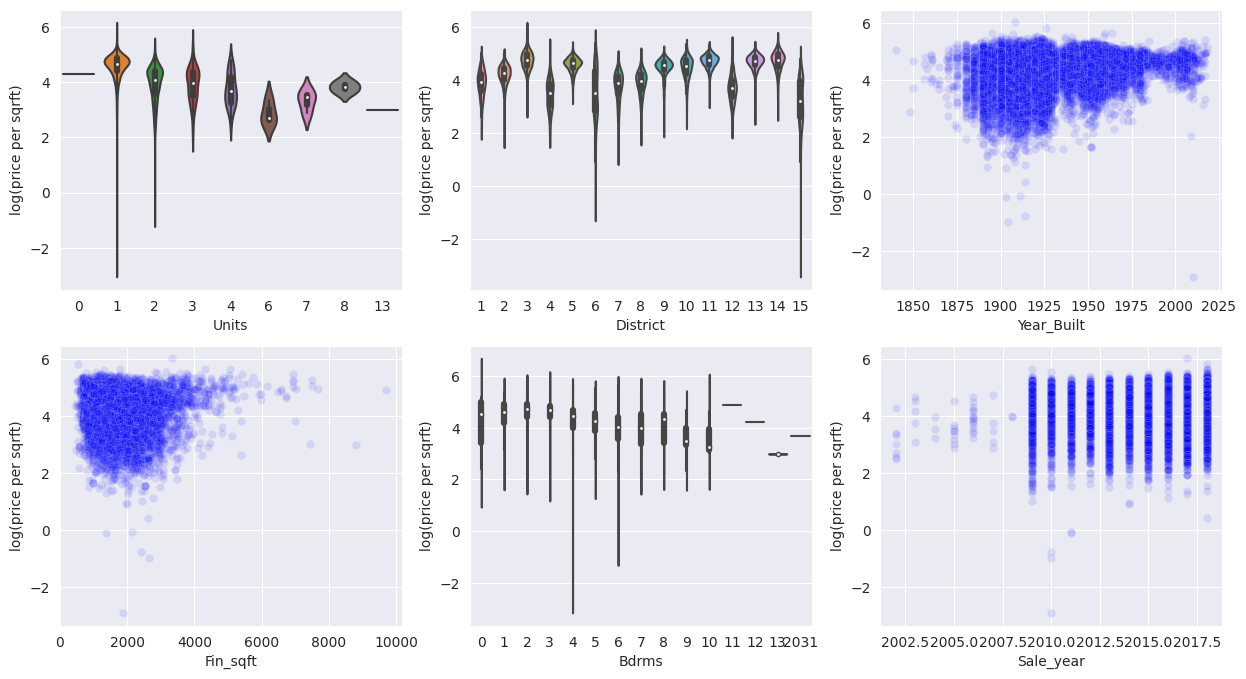

In [12]:
varstolook = ["Units", "District", "Year_Built", "Fin_sqft", "Bdrms", "Sale_year"]
data_clean2=data_clean.copy()
data_clean2["log(price per sqrft)"] = np.log(data_clean["Sale_price"]/data_clean["Fin_sqft"])
###
plt.figure(figsize=(15,8))
for i,var in enumerate(varstolook):
    plt.subplot(2,3,i+1)
    if var in ["Units","District","Bdrms"]:
        sns.violinplot(x=var, y="log(price per sqrft)", data=data_clean2)
    else:
        sns.scatterplot(x=var, y="log(price per sqrft)", data=data_clean2,
                        alpha=0.10, color="b")

In [13]:
px.violin(data_clean2, x='log(price per sqrft)', y='Bdrms')

In [14]:
data_clean2['Bdrms'].value_counts()

3       12597
4        5738
2        3216
5        1352
6        1224
7         123
1          91
8          73
9          20
0           8
10          3
13          2
12          1
11          1
2031        1
Name: Bdrms, dtype: int64

In [15]:
px.violin(data_clean2, y='log(price per sqrft)', x='Bdrms')

In [16]:
px.box(data_clean2, y='log(price per sqrft)', x='Bdrms')

In [17]:
px.box(data_clean2, y='log(price per sqrft)', x='District')

In [18]:
px.scatter(data_clean2, y='log(price per sqrft)', x='Year_Built')

#### ***1.2***

¿Qué puedes concluir de estos diagramas exploratorios? Seleccione todas las que correspondan.

(a) Las propiedades construidas en los últimos diez años tienden a ser más valiosas (por pie cuadrado)

(b) Dividir una propiedad de una sola unidad en unidades más pequeñas tendería a hacerla más valiosa

(c) Muchas de las propiedades más valiosas están en los distritos 3 y 14

(d) Tener más dormitorios hace que una propiedad sea menos valiosa



***Respuesta.***

---

(a) **Falso**. Algunas de las propiedades más valiosas (pero también algunas de las propiedades *menos* valiosas) son más antiguas. No hay una tendencia claramente perceptible.

(b) **Falso**. Si bien esto puede ser cierto, no se puede ver solo en este plot. De hecho, los gráficos muestran que las propiedades con más unidades suelen ser *menos* valiosas por pie cuadrado que las propiedades de una sola unidad. Puede ser razonable inferir que los residentes de Milwaukee tienen una marcada preferencia por vivir en sus propias casas. Pero las propiedades de una sola unidad y las de unidades múltiples difieren en otros aspectos (por ejemplo, pueden estar concentradas en diferentes vecindarios), lo que hace que sea imposible sacar conclusiones sólidas de este diagrama solo.

(c) **Verdadero**. De hecho, las colas superiores del diagrama de violín para los distritos 3 y 14 se extienden más que los otros distritos. Entonces, esos distritos tienen algunas de las propiedades más valiosas, al menos por pie cuadrado. Una mirada rápida a un [mapa](https://city.milwaukee.gov/ImageLibrary/Groups/electionAuthors/howtorun/maps/newdistrictmap2012.jpg) de los distritos muestra que ambos están cerca del lago Michigan y a poca distancia del Distrito central de negocios (Distrito 4).

(d) **Falso**. Si bien esto puede parecer cierto a partir del plot, es razonable sospechar que las propiedades con muchos dormitorios son más grandes y tienen varias unidades, lo que *confunde* la tendencia que se ve aquí.

#### ***Ejercicio 2.***

Ajustar una regresión lineal múltiple del precio de venta (`Sale_price`) contra el distrito (`District`), la cantidad de unidades (`Units`) y los pies cuadrados terminados (`Fin_sqft`). ¿Qué distritos reconoce el modelo que tienen las propiedades más valiosas? ¿Todos los coeficientes son significativos? Si no es así, ¿cómo debemos interpretar los coeficientes con un valor alto de $p$?

***Respuesta.***

---



El intercepeto corresponde a los precios del distrito 1 con 0 unidades y 0 metros terminados.

Como estamos tomando predios con área construida el intercepto no lo deberíamos interpretar para esta situación.

In [19]:
data_clean['Fin_sqft'].describe()

count    24450.000000
mean      1505.790429
std        624.854208
min        452.000000
25%       1082.000000
50%       1328.000000
75%       1785.000000
max       9698.000000
Name: Fin_sqft, dtype: float64

In [20]:
data_clean['Units'].value_counts()

1     19909
2      4273
3       228
4        30
6         3
7         3
8         2
0         1
13        1
Name: Units, dtype: int64

In [21]:
data_clean['District'].unique()

array([ 7,  3,  4, 12, 11,  1, 13,  8, 15,  6,  9,  2,  5, 10, 14])

In [22]:
model_lin = smf.ols(formula = "Sale_price ~ C(District) + Units+ Fin_sqft",
                 data = data_clean).fit()
print(model_lin.summary())

                            OLS Regression Results                            
Dep. Variable:             Sale_price   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     3165.
Date:                Thu, 24 Aug 2023   Prob (F-statistic):               0.00
Time:                        23:17:13   Log-Likelihood:            -2.9839e+05
No. Observations:               24450   AIC:                         5.968e+05
Df Residuals:                   24433   BIC:                         5.969e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2.148e+04   1775.10

$$H_{0}:\ \ \beta_i = 0$$

$$V.S$$

$$H_{1}:\ \ \beta_i \neq 0$$

El modelo reconoce a los distritos (`District`) 3 y 14 como los que tienen las propiedades más valiosas. Esto concuerda con nuestros hallazgos del ***Ejercicio 1***.
Además, vemos que los coeficientes para los Distritos 12 y 8 no son significativos. Concluimos que no existe una diferencia estadísticamente significativa entre los precios de las propiedades de los Distritos 1 y 8, y los Distritos 1 y 12, *una vez que se toma en cuenta* el número de unidades y pies cuadrados terminados de las propiedades.


### ***Inspección de los residuales para diagnosticar un modelo ajustado.***

La regresión lineal es conceptualmente simple, ajustamos una superficie a nuestros datos aún no todo es tan simple como eso. ***El análisis de residuales*** es una herramienta importante para diagnosticar muchos problemas que pueden afectar una regresión lineal.
Los “residuales” son la diferencia entre las observaciones $y$ y los valores ajustados correspondientes $\hat{y}$; visualmente es la distancia entre la superficie ajustada y los datos.

El análisis residual nos permite probar algunos de los supuestos teóricos que sustentan la regresión lineal. La versión corta es que la regresión lineal funciona mejor cuando los residuos están [distribuidos normalmente](https://en.wikipedia.org/wiki/Normal_distribution).

Hemos mencionado que "la regresión lineal supone que los datos se distribuyen normalmente", lo cual no es del todo correcto. La regresión lineal aún puede ser una herramienta útil y poderosa (¡y teóricamente justificada!) incluso si los datos se desvían de esta suposición. Dicho esto, una distribución con colas anchas es un problema particular para la regresión lineal, porque los puntos "en las colas" que están lejos de sus valores ajustados pueden afectar de manera desproporcionada los coeficientes ajustados y las predicciones. por ejemplo, ser causado por un punto decimal fuera de lugar cuando un empleado distraído ingresó manualmente los datos sin procesar en una hoja de cálculo, puede causar estragos en un modelo Se dice que dicho punto de datos tiene una alto **leverage** en el modelo.




#### ***Ejercicio 3.***

##### ***3.1***

Obtenga los residuos comparando las observaciones con los valores ajustados (`model_lin.fittedvalues`). Vamos a comprobar que se obtienen los mismos valores que en  `model_lin.resid`.



***Respuesta.***

---


`Python` calcula mucho para nosotros muchos atributos del modelo.

$$residuales = y-\hat{y}$$

si $$residuales > 0$$ entonces
$$y-\hat{y}>0$$ luego
$$y>\hat{y}$$

Si el residual es mayor que 0 se dice que el modelo subestimando para esa observación

In [23]:
pd.DataFrame({"Valores_originales":data_clean["Sale_price"],
              "Valores_ajustados":model_lin.fittedvalues,
              "Residuales_del_modelo":model_lin.resid})

,Valores_originales,Valores_ajustados,Residuales_del_modelo
0,42000,69872.321699,-27872.321699
1,145000,76467.069806,68532.930194
2,30000,-229511.262503,259511.262503
3,66500,-90827.213754,157327.213754
4,150500,552957.797009,-402457.797009
...,...,...,...
24445,58500,60502.108825,-2002.108825
24446,60000,63593.315146,-3593.315146
24447,56500,46563.015706,9936.984294
24448,62900,104071.954151,-41171.954151


#### ***3.2***

Trace un histograma y QQ-plot de los residuales. ¿Que se observa?
    
**Hint:** Para comparar el histograma de residuos con una distribución normal, use el argumento ```density=True``` de ```plt.hist```, que coloca el histograma en la misma escala que la distribución normal . Luego, use el código:

```python
xx = np.linspace(modelo_lin.resid.min(), modelo_lin.resid.max(), num=1000)
plt.plot(xx, scipy.stats.norm.pdf(xx, loc=0.0, scale=np.sqrt(model_lin.scale)),
    label="distribución normal")
```
para superponer la función de densidad de probabilidad de la distribución normal.

Para visualizar los valores atípicos en el histograma, podemos usar la función `rugplot()` en la biblioteca `seaborn`. A los efectos de este ejercicio, defina los valores atípicos como aquellos residuos que están a más de cuatro desviaciones estándar de cero.




In [24]:
print("Cantidad de variables explícativas (k)    :",model_lin.df_model)
print("Cantidad (n-k-1), ed, gl de los residuales:",model_lin.df_resid)

Cantidad de variables explícativas (k)    : 16.0
Cantidad (n-k-1), ed, gl de los residuales: 24433.0


In [25]:
sigma2 = model_lin.ssr/model_lin.df_resid
print("Estimación sigma²:             ",sigma2) ## Estimación de sigma cuadrado en el modelo.
print("Información dada por el modelo:", model_lin.scale)

Estimación sigma²:              2333488143.0900426
Información dada por el modelo: 2333488143.0900426


In [26]:
model_lin.ssr/len(data_clean)

2331865676.8964834

***Respuesta.***

---



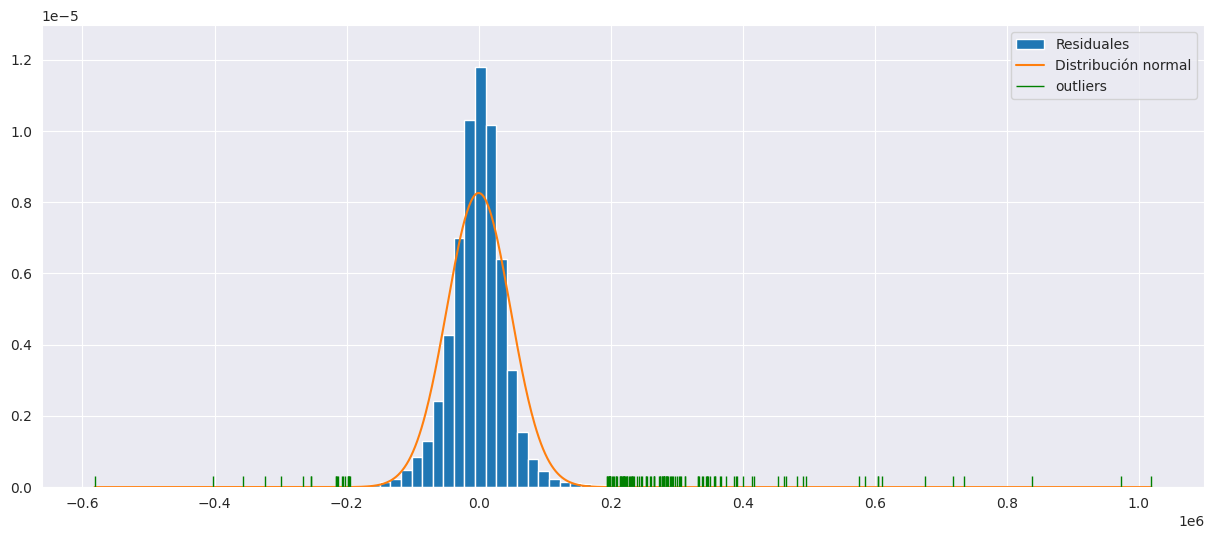

In [27]:
xx = np.linspace(model_lin.resid.min(), model_lin.resid.max(), num=1000) #1000 Números entre min-max resid
outliers = np.abs(model_lin.resid)>4*np.sqrt(model_lin.scale) ## Outliers más de 4 std's.
## El plot.
plt.figure(figsize=(15,6))
plt.hist(model_lin.resid, density = True, bins = 100, ## La integral vale 1, puede comparar con la normal.
         label = "Residuales")
plt.plot(xx, scipy.stats.norm.pdf(xx, loc = 0.0, scale = np.sqrt(model_lin.scale)),
         label="Distribución normal")                 ## La distribución normal para comparar
sns.rugplot(model_lin.resid[outliers], color = "green", label = "outliers")
plt.legend(loc="upper right")
plt.show()

También veamos el QQ-plot.

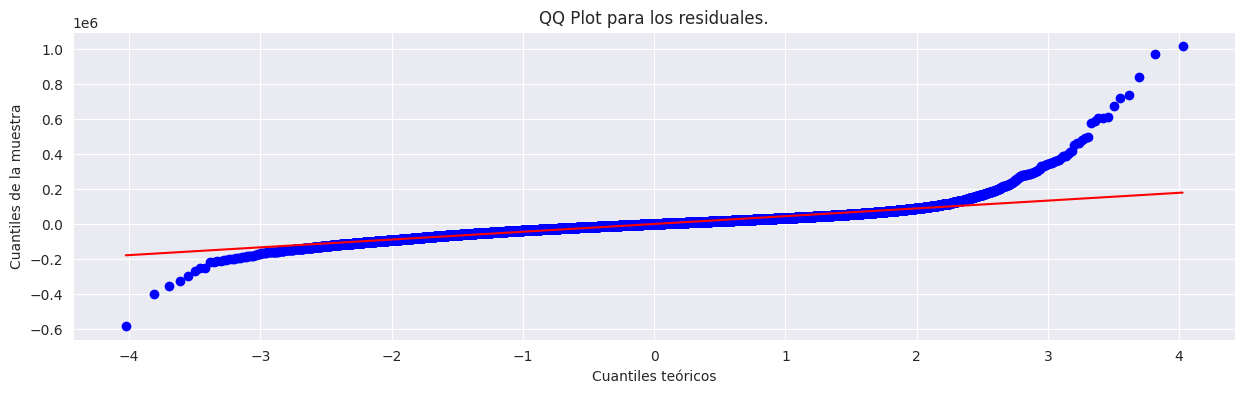

In [28]:
## Solo el QQ-plot.
plt.figure(figsize = (15,4))
scipy.stats.probplot(x = model_lin.resid, dist = "norm", plot = plt) ## QQ-plot.
plt.xlabel("Cuantiles teóricos")
plt.ylabel("Cuantiles de la muestra")
plt.title("QQ Plot para los residuales.")
plt.show()

Inmediatamente notamos algunas cosas:

1. El pico de los residuos es más alto que la distribución normal
2. La mayor parte de la distribución de los residuos es más estrecha que la distribución normal
3. Hay algunos valores atípicos grandes en ambos lados
4. Los residuos no son simétricos; es decir, hay algunos valores atípicos particularmente grandes en el lado derecho
5. El QQ-plot muestra la no linealidad, esto es otra señal de advertencia importante.

**NOTA:** Estamos enfatizando los diagnósticos visuales aquí, pero hay métricas informadas en la tabla de estadísticas de resumen para los residuales que contarán la misma historia: el [sesgo(skew)](https://en.wikipedia.org/wiki/Skewness) y una muy alta [kurtosis](https://en.wikipedia.org/wiki/Kurtosis) son motivo de preocupación.



Otra situación problemática que se puede detectar mediante el análisis de residuos es la **heteroscedasticidad**, lo que significa que los residuos tienen una variación pequeña en algunos subconjuntos de datos y una variación alta en otros. Vimos esto exactamente desde el principio en el caso anterior, con los puntos de datos "desplegándose" alrededor de la línea de mejor ajuste, y determinamos que esto causaría problemas. Lo opuesto a la heterocedasticidad es la **homocedasticidad**, que es lo que queremos ver en los datos y significa que los residuos tienen una varianza similar en todos los subconjuntos de datos.

In [29]:
data_clean['Sale_price'].describe()

count    2.445000e+04
mean     1.387963e+05
std      8.464923e+04
min      1.000000e+02
25%      9.320000e+04
50%      1.285000e+05
75%      1.640000e+05
max      1.650000e+06
Name: Sale_price, dtype: float64

#### ***Ejercicio 4.***

##### ***4.1***

Supongamos que nos dan datos de un par de casas en Milwaukee, digamos `house1` y `house2`. Usamos nuestro modelo para obtener un precio de venta recomendado para cada casa. El precio devuelto para `house1` fue $\$60,000$ y para `house2` fue $\$7,000,000$. Sabemos que el precio de venta final de cada casa será diferente, ya que depende de varios otros factores no incluidos en el modelo. Al final, el precio de venta real de cada casa estará en algún intervalo

$$
\begin{aligned}
 \$60,000-\verb*std1*&\leq \verb*house1* \leq \$60,000+\verb*std1*,\\
&\\
\$7,000,000-\verb*std2* &\leq \verb*house2*\leq \$7,000,000+\verb*std2*.
\end{aligned}
$$

¿Qué desviación esperaría que fuera mayor, `std1` o `std2`?

***Respuesta.***

---

Esperaríamos que `std2` fuera mucho más grande que `std1`. De hecho, un comprador interesado en una casa alrededor de $\$60k$ es probablemente un comprador que no tiene altos ingresos. Por lo tanto, tendría cuidado de no gastar más de $\$10k$ o $\$20k$ por encima de su presupuesto. Por el contrario, un comprador de una casa de alrededor de 7 millones probablemente tendría una flexibilidad mucho mayor en su presupuesto. Por lo tanto, para ellos agregar un costo adicional de $\$500k$ o más puede no importar mucho.

#### ***4.2***
Verifique sus hallazgos del Ejercicio 4.1 dibujando un diagrama de dispersión de los residuos contra los pies cuadrados. ¿Los residuos son homoscedásticos o heteroscedásticos?

**Hint:** Para ver un poco mejor los cambios en la varianza, también puede subdividir los datos en `Fin_sqft` en cuatro contenedores y dibujar diagramas de violín.

**Respuesta.**

---



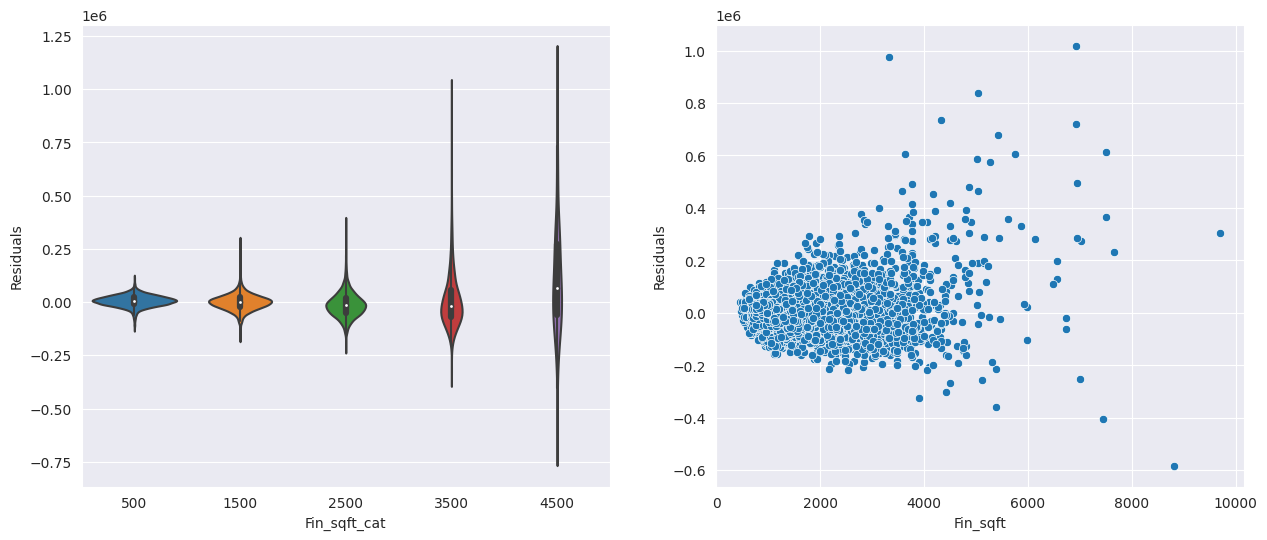

In [30]:
data_clean3 = data_clean.copy()
## Variable 'Fin_sqft' vista como categórica.
data_clean3['Fin_sqft_cat'] = pd.cut(data_clean3['Fin_sqft'], bins = [0, 1000, 2000, 3000, 4000, np.inf],
                                     labels = [500, 1500, 2500, 3500, 4500])
## Residuales.
data_clean3['Residuals'] = model_lin.resid.values
## Plots
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,6))
sns.violinplot(x='Fin_sqft_cat', y='Residuals', data = data_clean3, ax = ax[0])
sns.scatterplot(x = 'Fin_sqft', y = 'Residuals', data = data_clean3, ax = ax[1])
plt.show()

También podemos superponer el diagrama de violín sobre el diagrama de dispersión de la siguiente manera:

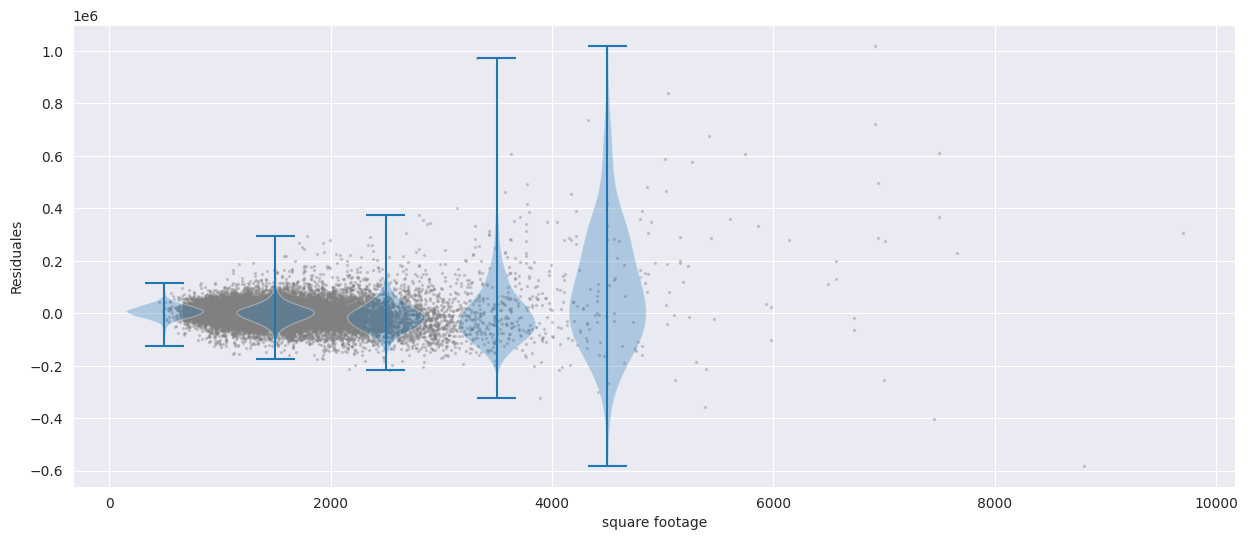

In [31]:
plt.figure(figsize = (15,6))
plt.scatter(data_clean["Fin_sqft"], model_lin.resid, s=2, alpha=0.3, color="grey") # Scatterplot.
sort_categories = np.sort(data_clean3['Fin_sqft_cat'].unique())
data_temp = [model_lin.resid.values[data_clean3['Fin_sqft_cat']==i] for i in sort_categories]
plt.violinplot(data_temp, positions=[500, 1500, 2500, 3500, 4500], widths=700) ## Violinplot
plt.xlabel("square footage")
plt.ylabel("Residuales")
plt.show()

Los diagramas de violín muestran que los residuos se ensanchan a medida que las propiedades se hacen más grandes, lo que demuestra la heteroscedasticidad.

Como nota al margen, la heteroscedasticidad es fácil de mostrar, pero la homoscedasticidad es difícil de demostrar, porque tenemos que mostrar que *ninguna* de las variables exhibe heteroscedasticidad. En general, usa tu *intuición* para buscar heteroscedasticidad; aquí, quizás era previsible que las casas pequeñas (y por lo tanto baratas) tuvieran un precio de venta más predecible que las casas grandes (caras).

### ***Transformando variables para mitigar problemas de residuos.***

Ya sabemos que los residuos son problemáticos en este caso, que hacemos?. Una posible solución es realizar una transformación de la variable de respuesta. Intentemos hacer que la variable de respuesta sea el logaritmo de `Sale_price`. Es una suposición natural que el precio de venta debe ser proporcional a los pies cuadrados de la propiedad. Por lo tanto, también tomaremos el logaritmo de los pies cuadrados como variable predictora en este modelo:

In [32]:
np.log(0+1)

0.0

Nota: En caso de tener una variable con sesgo a la derecha y querer aplicar log para corregir, y si la varaible tiene 0´s se puede usar la siguiente transformación

$$Log(x_1+1)$$

Con esto evita los problema de que al transformarla aparezca $-\infty$

<Axes: >

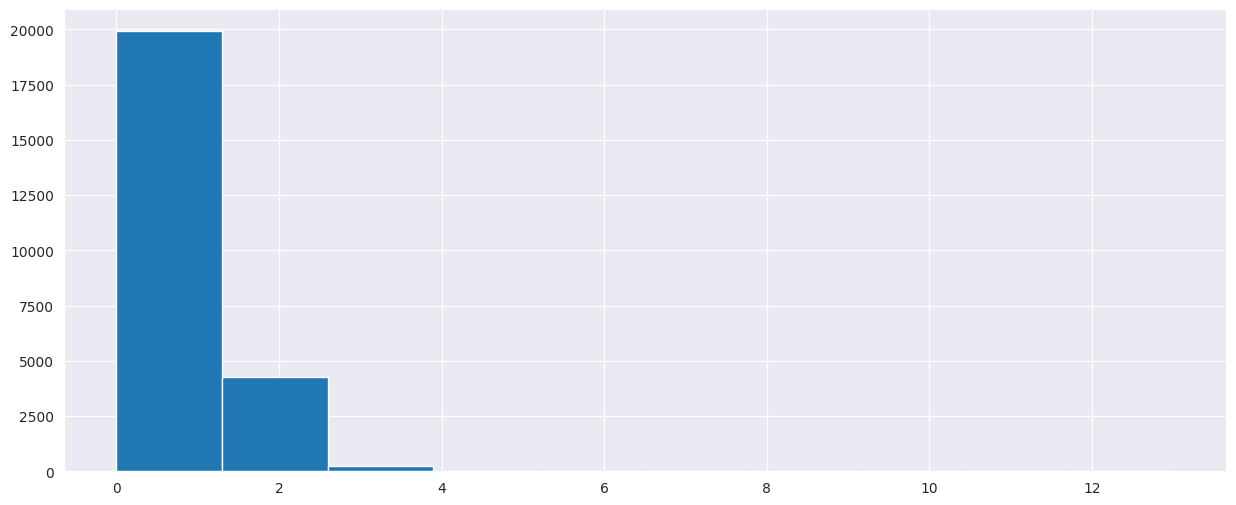

In [33]:
data_clean['Units'].hist()

In [34]:
model_log = smf.ols(formula = "np.log(Sale_price) ~ C(District) + Units+ np.log(Fin_sqft)",
                 data = data_clean).fit()
print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:     np.log(Sale_price)   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     2283.
Date:                Thu, 24 Aug 2023   Prob (F-statistic):               0.00
Time:                        23:17:18   Log-Likelihood:                -10020.
No. Observations:               24450   AIC:                         2.007e+04
Df Residuals:                   24433   BIC:                         2.021e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             5.2346      0.05

**Otro modelo con logs en ambas numericas**

In [35]:
model_log_log_units = smf.ols(formula = "np.log(Sale_price) ~ C(District) + np.log(Units+1)+ np.log(Fin_sqft)",
                 data = data_clean).fit()
print(model_log_log_units.summary())

                            OLS Regression Results                            
Dep. Variable:     np.log(Sale_price)   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     2347.
Date:                Thu, 24 Aug 2023   Prob (F-statistic):               0.00
Time:                        23:17:19   Log-Likelihood:                -9816.2
No. Observations:               24450   AIC:                         1.967e+04
Df Residuals:                   24433   BIC:                         1.980e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             5.3898      0.05

#### ***Ejercicio 5.***

##### ***5.1***

Trace un histograma de los residuales, similar a lo que se hizo en el ***Ejercicio 3***. ¿La transformación logarítmica solucionó los problemas de asimetría y valores atípicos que notamos anteriormente?

**Hint:** ¿Qué cambios en [Skewness](https://en.wikipedia.org/wiki/Skewness) y [Kurtosis](https://en.wikipedia.org/wiki/Kurtosis) se ve en el nuevo modelo?



In [36]:
print("Sesgo residuales model_lin:",scipy.stats.skew(model_lin.resid), "----> sesgada a la derecha")
print("Sesgo residuales model_log:",scipy.stats.skew(model_log.resid), "--> sesgada a la izquierda")

Sesgo residuales model_lin: 2.503982565043942 ----> sesgada a la derecha
Sesgo residuales model_log: -1.2723058350249068 --> sesgada a la izquierda


**Si fisher= True (es el valor por defecto) al valor de la curtosis se le resta 3**

<br>

**Si fisher= False el valor de la curtosis corresponde al cálculo y debería corresponde con el del resumen del modelo**

<br>
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html

In [37]:
print("Kurtosis N(0,1):", scipy.stats.kurtosis(np.random.normal(loc = 0, scale =1,size=10000), fisher=False))
print("Kurtosis residuales model_lin:", scipy.stats.kurtosis(model_lin.resid, fisher=False))
print("Kurtosis residuales model_log:", scipy.stats.kurtosis(model_log.resid, fisher=False))

Kurtosis N(0,1): 3.024532012838725
Kurtosis residuales model_lin: 40.82524646576179
Kurtosis residuales model_log: 13.560740359004916


***Respuesta.***

---



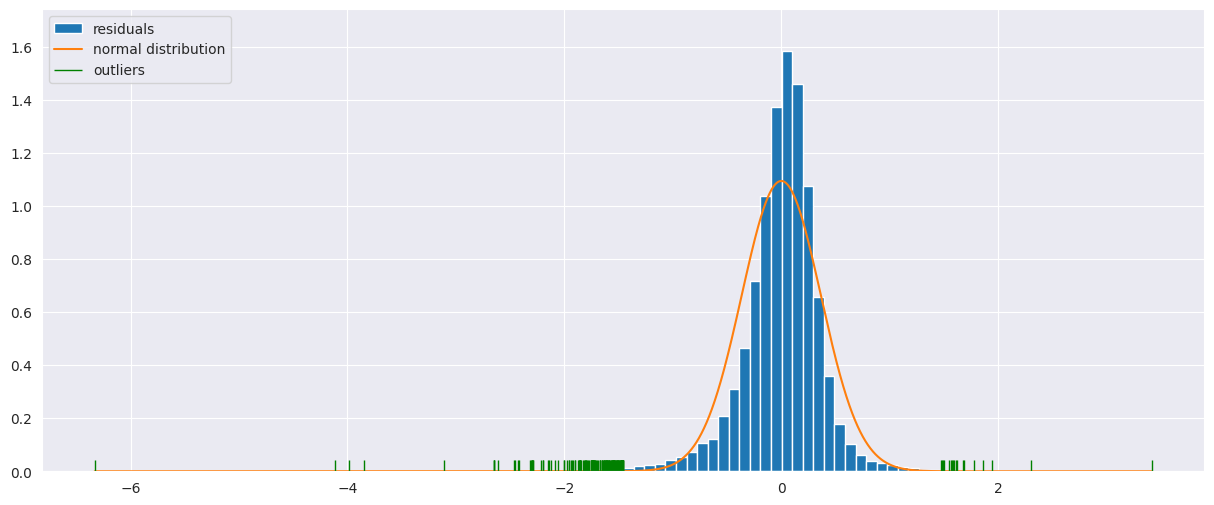

In [38]:
xx = np.linspace(model_log.resid.min(), model_log.resid.max(), num=10000)
##
plt.figure(figsize=(15,6))
plt.hist(model_log.resid, density = True, bins = 100, label="residuals")
plt.plot(xx, scipy.stats.norm.pdf(xx, loc=0.0, scale=np.sqrt(model_log.scale)),
         label="normal distribution")
sns.rugplot(model_log.resid[np.abs(model_log.resid)>4*np.sqrt(model_log.scale)], color = "green",
            label="outliers")
plt.legend(loc="upper left")
plt.show()

Visualmente, no es evidente que los residuos hayan mejorado. Sin embargo, mirar los detalles pinta una imagen diferente. No hay menos valores atípicos, pero muchos están ahora por debajo del pico en lugar de por encima. Los valores atípicos bajos son más fáciles de explicar como productos de factores externos conocidos que los valores atípicos altos; p.ej. si el propietario vende su casa a un amigo o pariente, o si la propiedad está en malas condiciones, entonces podría venderse a un precio muy reducido.

Los residuos también están menos sesgados y las colas de la distribución son menos gruesas. Esto se puede deducir de las métricas `Skew` y `Kurtosis` en la parte inferior de los resúmenes de los modelos (reproducidos a continuación por conveniencia):

In [39]:
print(model_lin.summary().tables[-1])

Omnibus:                    16670.121   Durbin-Watson:                   1.740
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1483125.778
Skew:                           2.504   Prob(JB):                         0.00
Kurtosis:                      40.825   Cond. No.                     3.26e+04


In [40]:
print(model_log.summary().tables[-1])

Omnibus:                     8475.447   Durbin-Watson:                   1.741
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           120216.866
Skew:                          -1.272   Prob(JB):                         0.00
Kurtosis:                      13.561   Cond. No.                         186.


#### ***5.2***

¿Mejoró el problema de heteroscedasticidad del ejercicio 4?

***Respuesta.***

---



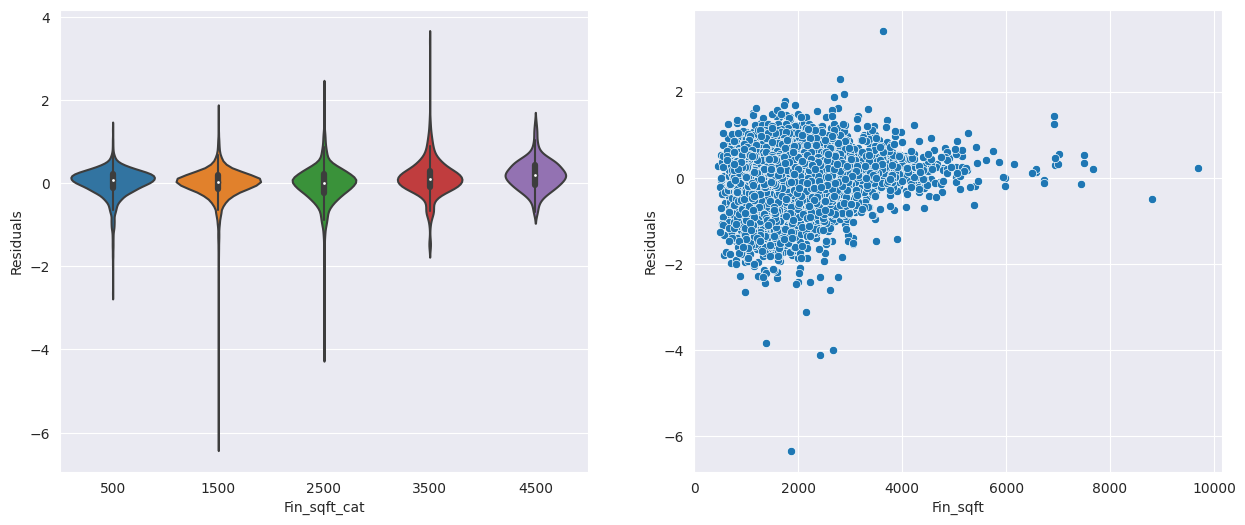

In [41]:
data_clean4 = data_clean.copy()
data_clean4['Fin_sqft_cat'] = pd.cut(data_clean4['Fin_sqft'], bins = [0, 1000, 2000, 3000, 4000, np.inf],
                                     labels = [500, 1500, 2500, 3500, 4500])
data_clean4['Residuals'] = model_log.resid.values
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,6))
sns.violinplot(x='Fin_sqft_cat', y='Residuals', data = data_clean4, ax = ax[0])
sns.scatterplot(x = 'Fin_sqft', y = 'Residuals', data = data_clean4, ax = ax[1])
plt.show()

También podemos superponer el diagrama de violín sobre el diagrama de dispersión de la siguiente manera:

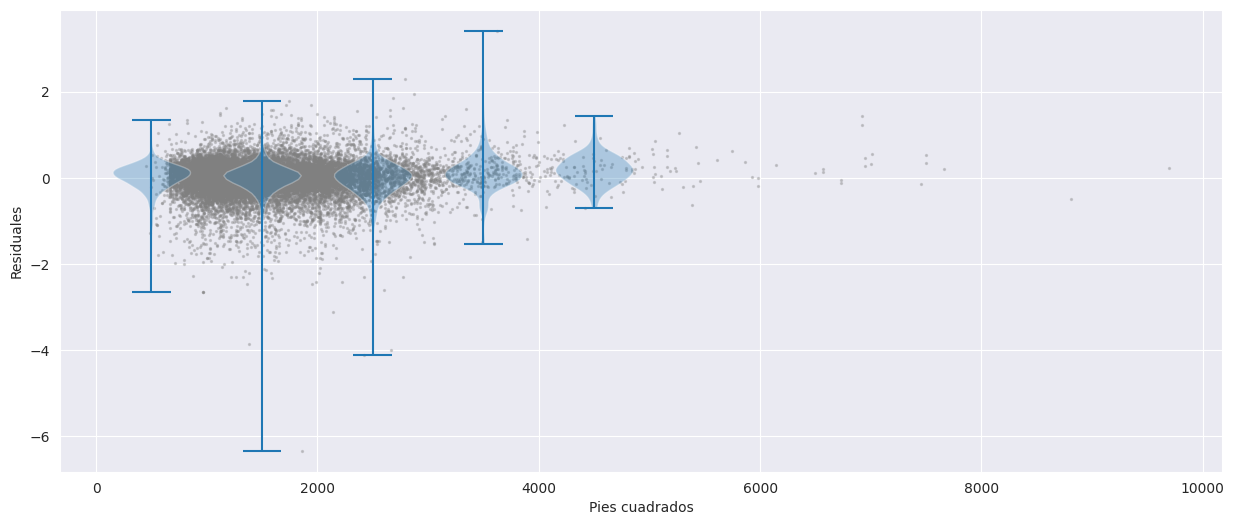

In [42]:
plt.figure(figsize = (15,6))
plt.scatter(data_clean["Fin_sqft"], model_log.resid, s=2, alpha=0.3, color="grey") # Scatterplot.
sort_categories = np.sort(data_clean4['Fin_sqft_cat'].unique())
data_temp = [model_log.resid.values[data_clean4['Fin_sqft_cat']==i] for i in sort_categories]
plt.violinplot(data_temp, positions=[500, 1500, 2500, 3500, 4500], widths=700) ## Violinplot
plt.xlabel("Pies cuadrados")
plt.ylabel("Residuales")
plt.show()

La distribución de los residuales en función de los pies cuadrados se ha estabilizado, lo que respalda el argumento de que la escala logarítmica es más natural para modelar los precios de las propiedades.

#### ***Ejercicio 6.***

##### 6.1

¿Cómo interpretamos el coeficiente de `Unit`?

In [43]:
print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:     np.log(Sale_price)   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     2283.
Date:                Thu, 24 Aug 2023   Prob (F-statistic):               0.00
Time:                        23:17:23   Log-Likelihood:                -10020.
No. Observations:               24450   AIC:                         2.007e+04
Df Residuals:                   24433   BIC:                         2.021e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             5.2346      0.05

In [44]:
model_log.params.loc['Units']

-0.3523015977955491

***Respuesta.***

---

En igualdad de condiciones, una unidad adicional reduce el logarítmico del precio de la propiedad en 0,35, lo que corresponde a una reducción del precio ligeramente inferior al 30 % (esto se calcula como $1-e^{-0.3523}$).

#### ***6.2***

¿Qué dice el coeficiente `np.log(Fin_sqft)` en este modelo?

(a) El precio de una propiedad es proporcional a sus pies cuadrados

(b) El precio de una propiedad baja con los pies cuadrados

(c) El precio de una propiedad sube logarítmicamente con sus pies cuadrados

(d) El precio de una propiedad sube exponencialmente con sus pies cuadrados

(e) El precio de una propiedad sube con los pies cuadrados, pero hay rendimientos decrecientes




In [45]:
model_log.params.loc["np.log(Fin_sqft)"]

0.8686683742384091

***Respuesta.***

---

(e). El coeficiente ajustado es 0,87, que es positivo pero menor que 1. Teniendo en cuenta que hemos tomado el logaritmo de `Fin_sqft`, esto implica un crecimiento *sublineal*; es decir, el precio de una propiedad sube con los pies cuadrados, pero hay rendimientos decrecientes. ¿Encuentras esto intuitivo o sorprendente?


### ***Tratamiento de valores atípicos.***  

Nuestro análisis de residuos muestra una serie de valores atípicos. Como se mencionó anteriormente, los valores atípicos bajos no son del todo inesperados; p.ej. cuando las personas venden una propiedad a amigos o familiares, o si la propiedad está en mal estado, el precio de venta podría ser significativamente más bajo de lo esperado por el modelo. No obstante, los valores atípicos pueden desestabilizar un modelo y reducir significativamente su capacidad predictiva a pesar de que solo representan un subconjunto marginal de los datos generales.

### ***Pregunta:***

¿Qué debe hacer un analista con los valores atípicos?

---
Es tentador simplemente eliminar puntos de datos con grandes residuos; sin embargo, este punto de vista adolece de un sesgo retrospectivo. Los valores atípicos con residuos altos no se pueden determinar antes de que se cree el modelo, lo que significa que no se pueden eliminar por adelantado.

Más bien, el punto de partida siempre debe ser inspeccionar los datos sin procesar iniciales en busca de puntos de datos con valores inusualmente pequeños o grandes para ciertas características y comprender por qué son diferentes. Si hay algo claramente erróneo con esos datos (como un punto decimal fuera de lugar), o si el motivo de estos valores pequeños o grandes puede explicarse efectivamente a través de un factor externo que no es capturado por los datos en sí, entonces esto justifica eliminarlos. De lo contrario, es mejor tener en cuenta estos puntos de datos durante todo el proceso de modelado y tratarlos durante el proceso de modelado en sí.

#### ***Ejercicio 7.***

Proporcione las características de la propiedad con el residuo absoluto más grande (es decir, el peor valor atípico en el conjunto de datos). Para esta propiedad, ¿cuál es el precio de venta ajustado (previsto) y real?

Encuentre todas las demás ventas de la misma propiedad en el conjunto de datos. ¿Puedes ver una explicación para estos valores atípicos extremos?




***Respuesta:***

---

El peor valor atípico es una casa que nuestro modelo predijo que debería venderse por alrededor de $\$56,000$,
y en su lugar se vendió por $\$100$. Esta misma casa fue vendida 8 meses antes por $\$189,000$, lo que confirma que $\$100$ no es el precio real de mercado. Podría ser, por ejemplo, una transacción entre parientes.


In [47]:
malisimo = np.abs(model_log.resid.values).argmax()
model_log.fittedvalues.iloc[malisimo]
#print("Valor que predice el modelo: ${:.0f}".format(np.exp()))

10.936206240748877

In [49]:
data_clean['Sale_price'].describe()

count    2.445000e+04
mean     1.387963e+05
std      8.464923e+04
min      1.000000e+02
25%      9.320000e+04
50%      1.285000e+05
75%      1.640000e+05
max      1.650000e+06
Name: Sale_price, dtype: float64

In [50]:
np.abs(model_log.resid.values).max()

6.331036054760785

In [48]:
malisimo = np.abs(model_log.resid.values).argmax()
print("Valor que predice el modelo: ${:.0f}".format(np.exp(model_log.fittedvalues.iloc[malisimo])))
print("="*100)
data_clean.iloc[malisimo] # Seleccionamos el registro con el residuo más grande.

Valor que predice el modelo: $56174


PropType             Residential
Taxkey                3515031000
Address           1938 N 19TH ST
CondoProject                 NaN
District                      15
Nbhd                        3000
Style                   Colonial
Extwall         Aluminum / Vinyl
Stories                      2.0
Year_Built                  2010
Nr_of_rms                      0
Fin_sqft                    1860
Units                          1
Bdrms                          4
Fbath                          3
Hbath                          1
Lotsize                     5681
Sale_price                   100
Sale_year                   2010
Name: 3710, dtype: object

In [52]:
data_clean.iloc[malisimo]["Taxkey"]

3515031000

In [54]:
mask_id.sum()

2

In [53]:
# Todas las ventas de esa propiedad.
mask_id = data_clean["Taxkey"] == data_clean.iloc[malisimo]["Taxkey"]
data_clean.loc[mask_id,["Sale_year","Sale_price"]]

,Sale_year,Sale_price
2525,2010,189000
3710,2010,100


---

El diagrama de dispersión a continuación muestra los residuales frente al precio de venta de todas las propiedades en los datos. El grupo en la esquina inferior izquierda muestra propiedades que se vendieron a un precio mucho más bajo de lo esperado por el modelo, lo que puede explicarse como transacciones por debajo de la tasa de mercado entre amigos o parientes. Esto justificaría la eliminación de todas las transacciones por debajo de $2000 del conjunto de datos antes de volver a ejecutar el análisis:




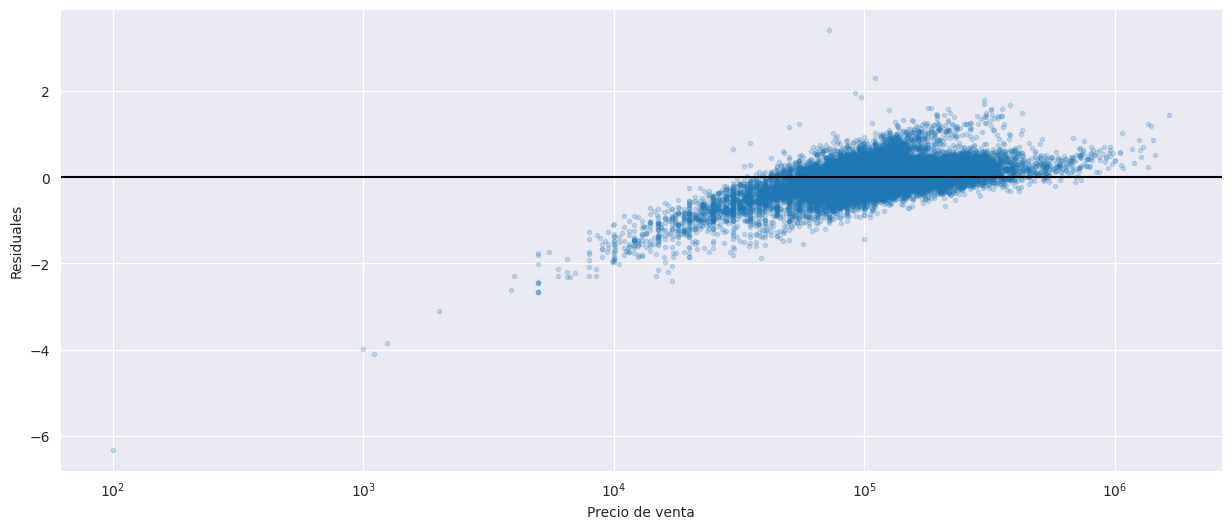

In [55]:
## Gráfica con escala logarítmica en el eje x. Cambia el eje x a la escala de registro.
plt.figure(figsize = (15,6))
plt.semilogx(data_clean["Sale_price"], model_log.resid, ".", alpha=0.2)
plt.ylabel("Residuales")
plt.xlabel("Precio de venta")
plt.axhline(0, color="black")
plt.show()

Podemos cuantificar el efecto de estos valores atípicos eliminándolos y volviendo a ejecutar la regresión, y viendo cómo cambian los coeficientes ajustados.

#### ***Ejercicio 8.***

##### ***8.1***

Vuelva a ejecutar el mismo modelo con un conjunto de datos reducido que elimine todos los valores atípicos con residuos absolutos superiores a 1,5.

1. ¿Qué porcentaje de los datos se elimina?
2. ¿Cuál es el valor del coeficiente de `Units` ajustado antes y después de eliminar los valores atípicos?
3. ¿Es significativa la diferencia?
4. ¿Qué coeficientes se mueven por más de dos errores estándar después de eliminar los valores atípicos?



***Respuesta.***

---



In [56]:
### model_log.scale: Varinaza de los residuales.
std_model_log = model_log.scale**(0.5)
print("- La desviacion estandar de los residuales es:        ", std_model_log)
print("- 4 veces la desviacion estandar de los residuales es:", 4*std_model_log)

- La desviacion estandar de los residuales es:         0.36465848410525353
- 4 veces la desviacion estandar de los residuales es: 1.4586339364210141


In [57]:
outliers = np.abs(model_log.resid) < 1.5 ## No outliers
data_noout = data_clean.loc[outliers, :]
## Nuevo modelos sin los valores atípicos.
model_noout = smf.ols(formula = "np.log(Sale_price) ~ C(District) + Units+ np.log(Fin_sqft)",
                      data = data_noout).fit()
##
print("{:.2f}% de la Data eliminada:".format((1-data_noout.size/data_clean.size)*100))
print("Coeficiente de `Units` en el modelo completo: {:.3f}".format(model_log.params["Units"]))
print("Coeficiente de `Units` en el modelo sin outliers: {:.3f}".format(model_noout.params["Units"]))

0.56% de la Data eliminada:
Coeficiente de `Units` en el modelo completo: -0.352
Coeficiente de `Units` en el modelo sin outliers: -0.382


In [58]:
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(Sale_price)   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     2283.
Date:                Thu, 24 Aug 2023   Prob (F-statistic):               0.00
Time:                        23:35:48   Log-Likelihood:                -10020.
No. Observations:               24450   AIC:                         2.007e+04
Df Residuals:                   24433   BIC:                         2.021e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             5.2346      0.057     91.435      0.000       5.122       5.347
C(District)[T.2]      0.3132      0.015     20.827      0.000       0.284       0.343
C(District)[T.3]      1.0223      0.015     66.953      0.000       0.992       1.052
C(District)[T.4]     -0.1997      0.031     -6.464      0.000      -0.260      -0.139
C(District)[T.5]      0.6896      0.013     53.242      0.000       0.664       0.715
C(District)[T.6]     -0.1841      0.018    -10.103      0.000      -0.220      -0.148
C(District)[T.7]     -0.0692      0.016     -4.272      0.000      -0.101      -0.037
C(District)[T.8]      0.1567      0.017      9.050      0.000       0.123       0.191
C(District)[T.9]      0.5799      0.016     36.764      0.000       0.549       0.611
C(District)[T.10]     0.6272      0.013     46.510      0.000       0.601       0.654
C(District)[T.11]     0.8221      0.013     63.362      0.000       0.797       0.847
C(District)[T.12]    -0.0038      0.021     -0.183      0.854      -0.045       0.037
C(District)[T.13]     0.8019      0.013     59.694      0.000       0.776       0.828
C(District)[T.14]     0.8701      0.013     64.855      0.000       0.844       0.896
C(District)[T.15]    -0.4857      0.020    -24.462      0.000      -0.525      -0.447
Units                -0.3523      0.006    -55.450      0.000      -0.365      -0.340
np.log(Fin_sqft)      0.8687      0.008    104.173      0.000       0.852       0.885
==============================================================================
Omnibus:                     8475.447   Durbin-Watson:                   1.741
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           120216.866
Skew:                          -1.272   Prob(JB):                         0.00
Kurtosis:                      13.561   Cond. No.                         186.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
model_log.bse

Intercept            0.057249
C(District)[T.2]     0.015040
C(District)[T.3]     0.015270
C(District)[T.4]     0.030897
C(District)[T.5]     0.012952
C(District)[T.6]     0.018222
C(District)[T.7]     0.016208
C(District)[T.8]     0.017313
C(District)[T.9]     0.015773
C(District)[T.10]    0.013485
C(District)[T.11]    0.012974
C(District)[T.12]    0.020979
C(District)[T.13]    0.013433
C(District)[T.14]    0.013416
C(District)[T.15]    0.019855
Units                0.006354
np.log(Fin_sqft)     0.008339
dtype: float64

In [59]:
# ¿Cuántos errores estándar (SE) del modelo completo se mueven los coeficientes
# después de quitar los outliers?
move = (model_log.params-model_noout.params)/model_log.bse
move[np.abs(move)>2] # Coeficientes que se movieron más de 2 SE (errores estándar)

C(District)[T.6]    -3.645634
C(District)[T.15]   -2.044336
Units                4.660283
dtype: float64

Este procedimiento solo elimina alrededor del 0,5% de los datos, pero el coeficiente de `Units` cambia significativamente de $-0,352$ a $-0,382$. Puede que esto no parezca mucho, pero el error estándar de este coeficiente fue 0,006, por lo que la estimación se ha desplazado en casi ***cinco errores estándar***, lo que de hecho es un cambio significativo.


In [ ]:
(0.382-0.352)/0.006

5.000000000000004

#### ***8.2***

Compruebe si las propiedades particularmente pequeñas o grandes también tienden a generar valores atípicos.


***Respuesta.***

---

No. Como se puede ver en el diagrama de residuos a continuación, no hay un grupo notable de propiedades lejos de la línea cero:

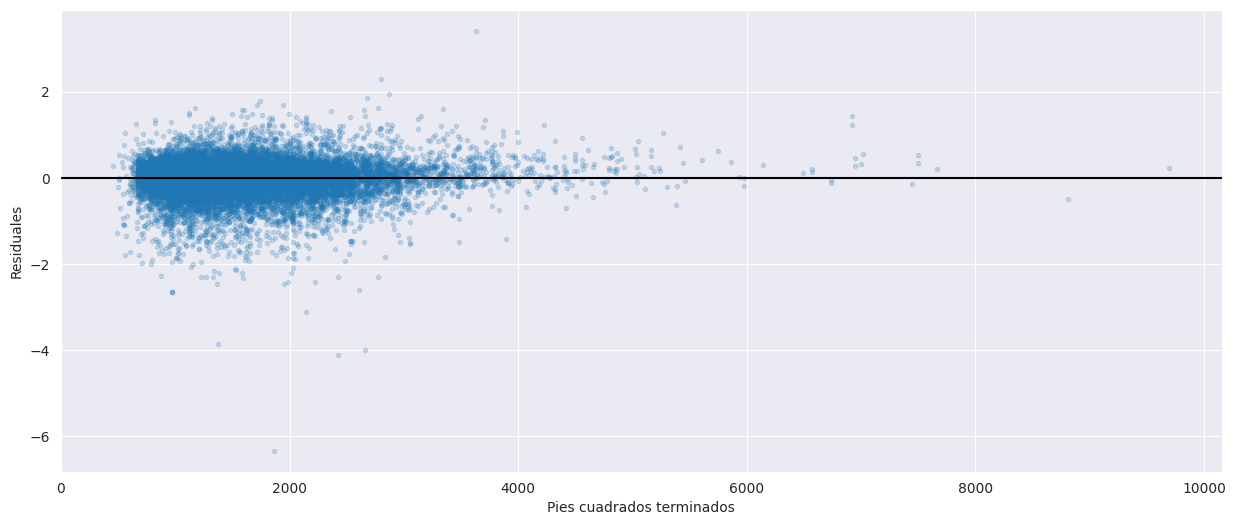

In [60]:
plt.figure(figsize=(15,6))
plt.plot(data_clean["Fin_sqft"], model_log.resid, ".", alpha=0.2)
plt.ylabel("Residuales")
plt.xlabel("Pies cuadrados terminados")
plt.axhline(0, color="black")
plt.show()

La protuberancia en el centro del diagrama de dispersión de los residuos de arriba puede parecer heteroscedasticidad. Sin embargo, este efecto puede aparecer simplemente porque muchas propiedades tienen entre 1,000 y 2,000 pies cuadrados, lo que hace que el gráfico de dispersión se "abulte" en el medio. Puede construir una gráfica de violín con los mismos datos para disipar cualquier duda sobre esta afirmación.

In [76]:
tam = 50
simul_normal = np.random.normal(loc=0, scale=1, size=tam)
simul_normal.min(), simul_normal.max()

(-2.2827225289436446, 1.9442686558673514)

In [82]:
tam = 50000
simul_normal = np.random.normal(loc=0, scale=1, size=tam)
simul_normal.min(), simul_normal.max()

(-4.043321105750774, 3.8761936312636256)

## ***Conclusiones.***

Hicimos una regresión lineal para predecir el precio de venta de una propiedad en Milwaukee, Wisconsin, e ilustramos algunos problemas potenciales con la regresión lineal. Cuando se violan gravemente algunos de los supuestos de la regresión lineal, como la normalidad de los residuos y la homocedasticidad, el modelo ajustado puede desestabilizarse. Como ejemplo, vimos cómo un pequeño número de valores atípicos puede cambiar un coeficiente ajustado por varios errores estándar.

## ***Observaciones.***

En este caso hemos aprendido:
    
1. Cómo reconocer la heterocedasticidad en los residuales y por qué es importante tratarla.
2. Cómo puede ser útil transformar la variable de resultado para reducir la asimetría y aliviar parte de la heteroscedasticidad presente en los residuos.
3. Cómo tratar adecuadamente los valores atípicos en los residuos. Reconocemos que siempre es mejor comprender el significado detrás de algunos de los valores atípicos para descartarlos de manera segura de nuestros modelos. En este caso, una transformación logarítmica del precio de venta solucionó muchos de los problemas del modelo. Sin embargo, otros conjuntos de datos pueden invitar a diferentes transformaciones. Debe combinar la intuición y la experimentación para encontrar la transformación correcta para usar.
5. Cómo realizar un análisis residual al utilizar la regresión lineal en sus proyectos. Como hemos visto, esto lo ayudará a mejorar no solo la calidad de sus modelos, sino también su intuición y experiencia al realizar futuros análisis de datos en el trabajo.







## ***Créditos.***

"Property sales data, 2002-2018 Master File",2020, Milwaukee OpenData, Creative Commons Attribution, https://data.milwaukee.gov/dataset/property-sales-data/resource/f083631f-e34e-4ad6-aba1-d6d7dd265170